In [12]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, I/O csv 
import pathlib
import PIL
import tensorflow as tf

import re
from collections import Counter

from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_sample_image

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [3]:
# import keras functions
from keras import Sequential

'''
Since we're using transfer learning let's import the model we want to implement. Let's use
VGG 19 layers and Resnet-50 (50 layers of residual units)
Residual units allow us to add more layers onto the model without a degradation in accuracy.

We ll try to compare the accuracy of 2 models and see if the additional layers do make a significant difference.
'''

from keras.applications import VGG19, ResNet50

' Import the datagenerator to augment images '
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

'''
Import the optimizers and learning rate annealer -> which will reduce the learning rate once a particular
metric we choose does not reduce after a user defined number of epochs.
'''

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout, MaxPooling2D, Conv2D

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

In [88]:
config = {
    'train_path': './output/train',
    'valid_path': './output/val',
    'test_path': './testing',
    'checkpoints': './checkpoints'
}

classes = ['bedroom', # 0
    'coast', # 1
    'forest', # 2
    'highway', # 3
    'industrial', # 4
    'insidecity',# 5
    'kitchen', # 6
    'living-room',# 7           
    'mountain', # 8
    'office', #9            
    'open-country',#10      
    'store', # 11
    'street',#12    
    'suburb',#13          
    'tall-building', #14
]


batch_size = 8
resized_output = (200, 200)
num_classes= 15

SEED = 42

train_data_gen = ImageDataGenerator(rotation_range=50,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.3,
            horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0,rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,width_shift_range=0.2,height_shift_range=0.2, zoom_range=0.3,
            horizontal_flip=True,vertical_flip=True,fill_mode='constant', cval=0, rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_data_gen.flow_from_directory(config['train_path'], target_size=resized_output, batch_size=batch_size, classes=classes, class_mode='categorical',shuffle=True, seed=SEED)  
valid_gen = valid_data_gen.flow_from_directory(config['valid_path'],target_size=resized_output,batch_size=batch_size, classes=classes, class_mode='categorical', shuffle=False, seed=SEED)
test_gen = test_data_gen.flow_from_directory(config['test_path'],target_size=resized_output, batch_size=batch_size+2, shuffle=False,seed=SEED,class_mode=None,)

Found 1125 images belonging to 15 classes.
Found 375 images belonging to 15 classes.
Found 2985 images belonging to 1 classes.


In [89]:
new_model = tf.keras.models.load_model('./saved_model/my_model')

In [90]:
new_model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

46/46 [==============================] - 35s 698ms/step - loss: 0.7275 - accuracy: 0.7908


[0.7275394201278687, 0.79076087474823]

In [110]:
model = tf.keras.models.load_model('saved_model/my_model')

STEP_SIZE_TEST = test_gen.n//test_gen.batch_size
test_gen.reset()

pred = model.predict(test_gen, verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

# CSV file for kaggle submission

labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [k for k in predicted_class_indices]

299/299 [==============================] - 268s 888ms/step


In [112]:
len(predicted_class_indices)
max_value = max(predicted_class_indices)
min_value = min(predicted_class_indices)

print(min_value, max_value)

0 14


In [113]:
filenames = test_gen.filenames

def pred_to_original(pred):
    return labels[pred]

pred_mapped = [pred_to_original(k) for k in predictions]
image_names = []

for f in filenames:
    _, image_name = f.split('/')
    if image_name.split('.')[1] == 'jpg':
        image_names.append(image_name)

print(len(image_names), len(pred_mapped))
    
meta = {'image_name': image_names, 'category': pred_mapped}
dataframe = pd.DataFrame(data=meta)

2985 2985


In [114]:
dataframe

,image_name,category
0,0.jpg,insidecity
1,1.jpg,forest
2,10.jpg,open-country
3,100.jpg,open-country
4,1000.jpg,store
...,...,...
2980,995.jpg,coast
2981,996.jpg,tall-building
2982,997.jpg,open-country
2983,998.jpg,open-country


In [116]:
dataframe.to_csv(r'run3.txt', header=None, index=None, sep=' ', mode='a')

In [124]:
new_model.history.history

{}

In [126]:
import pickle
history = pickle.load(open('/tmp/trained-history', 'rb'))

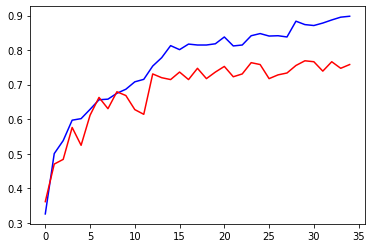

In [185]:
plt.plot(history['accuracy'],color='b',label='Training Loss')
plt.plot(history['val_accuracy'],color='r',label='Validation Loss')

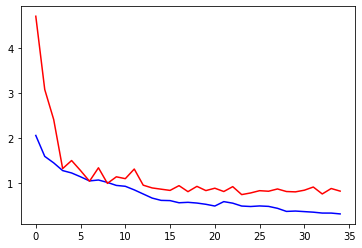

In [186]:
plt.plot(history['loss'],color='b',label='Training Loss')
plt.plot(history['val_loss'],color='r',label='Validation Loss')

In [180]:
model = tf.keras.models.load_model('saved_model/my_model')

In [181]:
y_pred = model.predict(valid_gen, verbose=1)

pred = np.argmax(y_pred, axis=1)

classes = []
for v, k in valid_gen.class_indices.items():
    classes.append(v)
classes

y_true = valid_gen.classes

47/47 [==============================] - 31s 613ms/step


<AxesSubplot:>

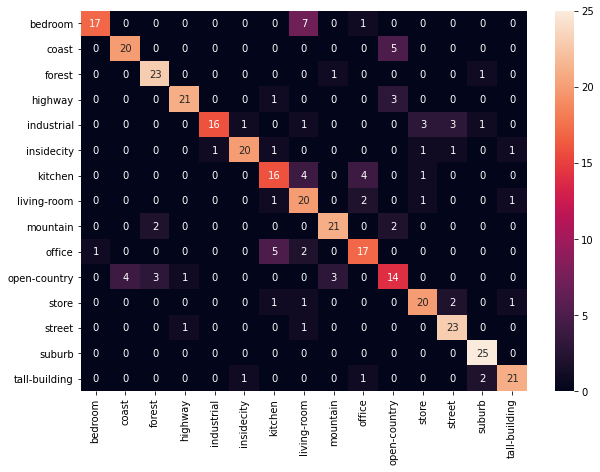

In [188]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, pred)

df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

array([[19,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 19,  1,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0],
       [ 0,  0, 19,  0,  2,  0,  0,  0,  2,  0,  1,  0,  0,  1,  0],
       [ 0,  1,  0, 20,  0,  0,  0,  0,  1,  0,  2,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 21,  0,  0,  1,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  4, 15,  1,  0,  0,  0,  0,  3,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0, 19,  2,  0,  3,  0,  1,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  1, 18,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0, 22,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  2,  0, 15,  0,  2,  0,  0,  1],
       [ 0,  4,  2,  0,  0,  0,  0,  0,  1,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  1,  3,  0,  1,  0, 15,  1,  1,  1],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0, 24,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25,  0],
       [ 0,  0,  0,  0,  0,  0,  0